<center> <h2><b>Machine Learning for Healthcare, Project 1: Time-Series</b></h2> </center>
<h3><b>Intensive Care Time Series Modeling for Mortality Predictions on 
the Physionet 2012 Challenge Dataset </b></h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### **1. Data Processing and Exploration (5 Pts)**
#### Q1.1: Data Transformation (1 Pts) 

In [2]:
def parse_data(dataset):
    """
    Parses the data from the given dataset directory and saves it as a parquet file.

    Parameters:
    dataset (str): The path to the dataset directory.

    Returns:
    None
    """
    filename = dataset[5:] + '.parquet'

    # If the file already exists, delete it and create a new one
    if os.path.exists(filename):
        os.remove(filename)

    # Read and compile all files in the directory
    txt_all = []
    for f in os.listdir(dataset):
        with open(os.path.join(dataset, f), 'r') as fp:
            txt = fp.readlines()

        # Get recordid to add as a column
        recordid = txt[1].rstrip('\n').split(',')[-1]
        txt = [t.rstrip('\n').split(',') + [int(recordid)] for t in txt]
        txt_all.extend(txt[1:])

    # Create DataFrame
    df = pd.DataFrame(txt_all, columns=['time', 'parameter', 'value', 'recordid'])
    df = df[df.parameter != 'RecordID']

    # Convert 'time' to hours and minutes and then to total minutes
    def time_to_minutes(time_str):
        hours, minutes = map(int, time_str.split(':'))
        return hours * 60 + minutes

    df['time_minutes'] = df['time'].apply(time_to_minutes)

    # Round up to the nearest hour
    df['time'] = ((df['time_minutes'] + 59) // 60).clip(upper=48)

    # Keep the most recent value by sorting and dropping duplicates
    df.sort_values(by=['recordid', 'time', 'time_minutes'], ascending=[True, True, False], inplace=True)
    df.drop_duplicates(subset=['recordid', 'time', 'parameter'], keep='first', inplace=True)

    # Pivot the DataFrame
    df_pivot = df.pivot_table(index=['recordid', 'time'], columns='parameter', values='value', aggfunc='first').reset_index()

    # Ensure all patients have 49 rows (0 to 48 hours)
    all_hours = pd.DataFrame({'time': range(49)})

    patients = df['recordid'].unique()
    patient_hours = pd.MultiIndex.from_product([patients, all_hours['time']], names=['recordid', 'time'])

    # Reindex to include all patient-hour combinations
    final_df = df_pivot.set_index(['recordid', 'time']).reindex(patient_hours).reset_index()

    # Convert time column into timesteps
    final_df['time'] = final_df['time'].apply(lambda x: f'{x:02}:00')

    static_columns = ["Age", "Gender", "Height", "ICUType", "Weight"]

    # Remove -1 values and propagate the static values to all the rows
    for col in static_columns:
        final_df[col] = final_df[col].astype(float).replace(-1, np.nan)
        final_df[col] = final_df.groupby('recordid')[col].transform(lambda x: x.ffill().bfill())
    
    for col in final_df.columns:
        try:
            final_df[col] = pd.to_numeric(final_df[col], errors='raise')
            # If all values are integers, convert to int
            if final_df[col].apply(float.is_integer).all():
                final_df[col] = final_df[col].astype(int)
        except:
            pass  # Keep as is if conversion fails

    # Fill None missing values with NaN
    final_df = final_df.fillna(value=np.nan)

    final_df.to_parquet(filename, index=False)

def extract_labels(outcome):
    """
    Extracts the labels from the given outcome file and saves it as a parquet file.

    Parameters:
    outcome (str): The path to the outcome file.

    Returns:
    None
    """
    filename = outcome[5:-4].lower() + '.parquet'

    # If the file already exists, delete it and create a new one
    if os.path.exists(filename):
        os.remove(filename)

    with open(outcome, 'r') as fp:
        txt = fp.readlines()
    
    labels = []
    for line in txt[1:]:  # Skip header
        parts = line.strip().split(',')
        recordid = int(parts[0])
        in_hospital_death = int(parts[-1])
        labels.append((recordid, in_hospital_death))

    labels_df = pd.DataFrame(labels, columns=['recordid', 'in_hospital_death'])
    labels_df.to_parquet(filename, index=False)

In [3]:
# For the notebook to run, we suppose the data is inside a 'data' folder
dataset_paths = ['data/set-a', 'data/set-b', 'data/set-c']
outcome_paths = ['data/Outcomes-a.txt', 'data/Outcomes-b.txt', 'data/Outcomes-c.txt']

# Only need to run once
# for dataset in dataset_paths:
#     parse_data(dataset)

# for outcome in outcome_paths:
#     extract_labels(outcome)

# Read the parsed data saved as parquet files
X_set_a, X_set_b, X_set_c = pd.read_parquet('set-a.parquet'), pd.read_parquet('set-b.parquet'), pd.read_parquet('set-c.parquet')
Y_set_a, Y_set_b, Y_set_c = pd.read_parquet('outcomes-a.parquet'), pd.read_parquet('outcomes-b.parquet'), pd.read_parquet('outcomes-c.parquet')

# From X_set_c drop unnamed parameter column
X_set_c = X_set_c.drop(columns='')

print(X_set_a.shape, X_set_b.shape, X_set_c.shape)
print(Y_set_a.shape, Y_set_b.shape, Y_set_c.shape)

(196000, 43) (196000, 43) (196000, 43)
(4000, 2) (4000, 2) (4000, 2)


In [4]:
X_set_a

recordid   time  ALP  ALT  AST  Age  Albumin  BUN  Bilirubin  \
0         132539  00:00  NaN  NaN  NaN   54      NaN  NaN        NaN   
1         132539  01:00  NaN  NaN  NaN   54      NaN  NaN        NaN   
2         132539  02:00  NaN  NaN  NaN   54      NaN  NaN        NaN   
3         132539  03:00  NaN  NaN  NaN   54      NaN  NaN        NaN   
4         132539  04:00  NaN  NaN  NaN   54      NaN  NaN        NaN   
...          ...    ...  ...  ...  ...  ...      ...  ...        ...   
195995    142673  44:00  NaN  NaN  NaN   78      NaN  NaN        NaN   
195996    142673  45:00  NaN  NaN  NaN   78      NaN  NaN        NaN   
195997    142673  46:00  NaN  NaN  NaN   78      NaN  NaN        NaN   
195998    142673  47:00  NaN  NaN  NaN   78      NaN  NaN        NaN   
195999    142673  48:00  NaN  NaN  NaN   78      NaN  NaN        NaN   

        Cholesterol  ...  RespRate  SaO2  SysABP  Temp  TroponinI  TroponinT  \
0               NaN  ...       NaN   NaN     NaN   NaN        NaN        NaN   
1               NaN  ...      19.0   NaN     NaN  35.6        NaN        NaN   
2               NaN  ...      18.0   NaN     NaN   NaN        NaN        NaN   
3               NaN  ...      19.0   NaN     NaN   NaN        NaN        NaN   
4               NaN  ...      20.0   NaN     NaN  37.8        NaN        NaN   
...             ...  ...       ...   ...     ...   ...        ...        ...   
195995          NaN  ...       NaN  98.0   112.0  37.7        NaN        NaN   
195996          NaN  ...       NaN   NaN   108.0  37.6        NaN        NaN   
195997          NaN  ...       NaN   NaN   112.0   NaN        NaN        NaN   
195998          NaN  ...       NaN   NaN   121.0  37.3        NaN        NaN   
195999          NaN  ...       NaN   NaN   129.0   NaN        NaN        NaN   

        Urine  WBC  Weight    pH  
0         NaN  NaN     NaN   NaN  
1        60.0  NaN     NaN   NaN  
2        30.0  NaN     NaN   NaN  
3       170.0  NaN     NaN   NaN  
4        60.0  NaN     NaN   NaN  
...       ...  ...     ...   ...  
195995   25.0  NaN    87.3  7.34  
195996   25.0  NaN    87.3   NaN  
195997   23.0  NaN    87.3  7.31  
195998   40.0  NaN    87.3   NaN  
195999   30.0  NaN    87.3   NaN  

[196000 rows x 43 columns]

In [5]:
X_set_a[X_set_a["recordid"] == 132539]

recordid   time  ALP  ALT  AST  Age  Albumin   BUN  Bilirubin  \
0     132539  00:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
1     132539  01:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
2     132539  02:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
3     132539  03:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
4     132539  04:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
5     132539  05:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
6     132539  06:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
7     132539  07:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
8     132539  08:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
9     132539  09:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
10    132539  10:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
11    132539  11:00  NaN  NaN  NaN   54      NaN  13.0        NaN   
12    132539  12:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
13    132539  13:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
14    132539  14:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
15    132539  15:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
16    132539  16:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
17    132539  17:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
18    132539  18:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
19    132539  19:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
20    132539  20:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
21    132539  21:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
22    132539  22:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
23    132539  23:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
24    132539  24:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
25    132539  25:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
26    132539  26:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
27    132539  27:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
28    132539  28:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
29    132539  29:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
30    132539  30:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
31    132539  31:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
32    132539  32:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
33    132539  33:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
34    132539  34:00  NaN  NaN  NaN   54      NaN   8.0        NaN   
35    132539  35:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
36    132539  36:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
37    132539  37:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
38    132539  38:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
39    132539  39:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
40    132539  40:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
41    132539  41:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
42    132539  42:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
43    132539  43:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
44    132539  44:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
45    132539  45:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
46    132539  46:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
47    132539  47:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
48    132539  48:00  NaN  NaN  NaN   54      NaN   NaN        NaN   

    Cholesterol  ...  RespRate  SaO2  SysABP  Temp  TroponinI  TroponinT  \
0           NaN  ...       NaN   NaN     NaN   NaN        NaN        NaN   
1           NaN  ...      19.0   NaN     NaN  35.6        NaN        NaN   
2           NaN  ...      18.0   NaN     NaN   NaN        NaN        NaN   
3           NaN  ...      19.0   NaN     NaN   NaN        NaN        NaN   
4           NaN  ...      20.0   NaN     NaN  37.8        NaN        NaN   
5           NaN  ...      20.0   NaN     NaN   NaN        NaN        NaN   
6           NaN  ... 

In [6]:
Y_set_a

recordid  in_hospital_death
0       132539                  0
1       132540                  0
2       132541                  0
3       132543                  0
4       132545                  0
...        ...                ...
3995    142665                  0
3996    142667                  0
3997    142670                  0
3998    142671                  1
3999    142673                  0

[4000 rows x 2 columns]

#### Q1.2 Exploratory Data Analysis (2 Pts)

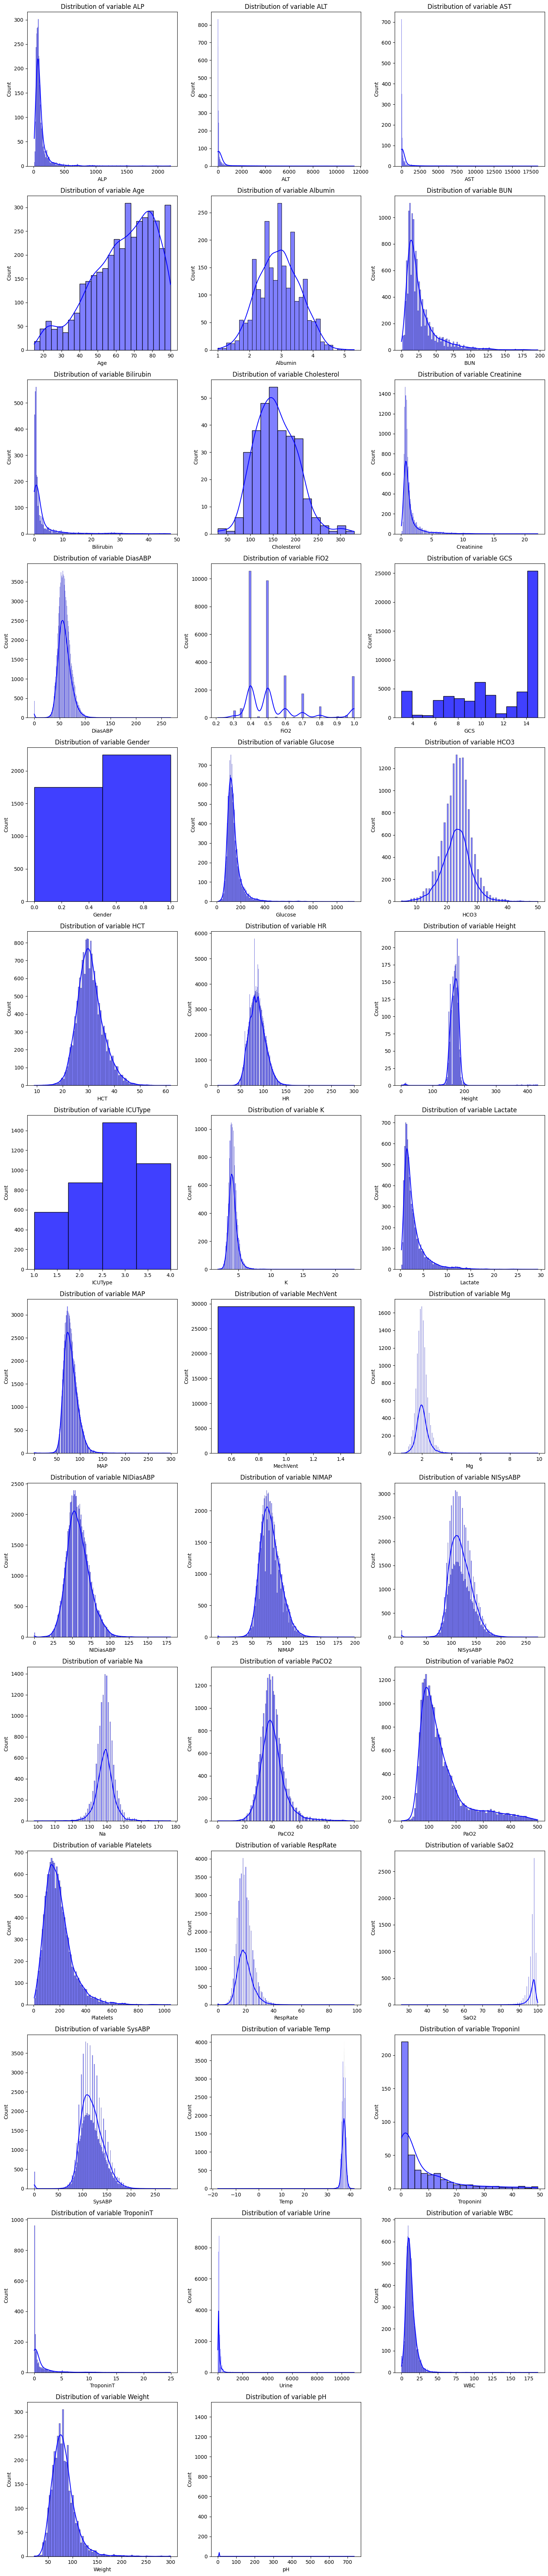

In [7]:
static_columns = ["Age", "Gender", "Height", "ICUType", "Weight"]

# Plot each column's distribution
def plot_distributions(df, static_columns):
    # Columns to exclude from the visualization plot
    exclude_cols = ['time', 'recordid']

    # Set up the plotting grid
    cols_to_plot = [col for col in df.columns if col not in exclude_cols]
    num_cols = len(cols_to_plot)

    plt.figure(figsize=(15, 5 * (num_cols // 3 + 1)))
    for i, col in enumerate(cols_to_plot, 1):
        plt.subplot((num_cols // 3) + 1, 3, i)
        if col in static_columns:  # Limit to one datapoint per recordid for static columns as values are present in multiple rows
            if col in ['Gender', 'ICUType']:  # Categorical and static variables
                bins = len(df[col].dropna().unique())  # Number of unique categories
                sns.histplot(df.groupby('recordid')[col].first(), bins=bins, color='blue')
            else:  # Other static and non-categorical variables
                sns.histplot(df.groupby('recordid')[col].first(), kde=True, color='blue')
        elif col in ['GCS', 'MechVent']:  # Categorical variables
            bins = len(df[col].dropna().unique())  # Number of unique categories
            sns.histplot(df[col], bins=bins, color='blue')
        else:
            sns.histplot(df[col], kde=True, color='blue')
        plt.title(f"Distribution of variable {col}")

    plt.tight_layout()
    plt.show()

plot_distributions(X_set_a, static_columns)

In [8]:
X_set_a['MechVent'].value_counts()

MechVent
1.0    29480
Name: count, dtype: int64

In [9]:
pd.set_option('display.max_columns', None)
X_set_a.describe()

recordid          ALP           ALT           AST            Age  \
count  196000.00000  3086.000000   3171.000000   3176.000000  196000.000000   
mean   137605.12200   116.746273    394.886471    505.541562      64.247500   
std      2923.25087   133.976599   1201.222503   1515.605791      17.558796   
min    132539.00000    12.000000      1.000000      4.000000      15.000000   
25%    135075.75000    59.000000     20.000000     31.000000      52.750000   
50%    137592.50000    82.000000     43.000000     64.000000      67.000000   
75%    140100.25000   122.000000    162.000000    209.000000      78.000000   
max    142673.00000  2205.000000  11470.000000  18430.000000      90.000000   

           Albumin           BUN    Bilirubin  Cholesterol    Creatinine  \
count  2353.000000  13889.000000  3186.000000   315.000000  13955.000000   
mean      2.922822     27.410858     2.906497   156.517460      1.505131   
std       0.651804     23.402503     5.902983    46.068097      1.636898   
min       1.000000      0.000000     0.100000    28.000000      0.100000   
25%       2.500000     13.000000     0.500000   123.000000      0.700000   
50%       2.900000     20.000000     0.900000   152.000000      1.000000   
75%       3.400000     33.000000     2.300000   188.000000      1.500000   
max       5.300000    197.000000    47.700000   330.000000     22.100000   

             DiasABP          FiO2           GCS         Gender       Glucose  \
count  103409.000000  30741.000000  61070.000000  195853.000000  12991.000000   
mean       59.541229      0.540513     11.407827       0.561921    141.384882   
std        13.008356      0.186372      3.967653       0.496152     67.282744   
min         0.000000      0.210000      3.000000       0.000000     10.000000   
25%        51.000000      0.400000      8.000000       0.000000    105.000000   
50%        58.000000      0.500000     13.000000       1.000000    127.000000   
75%        67.000000      0.600000     15.000000       1.000000    157.000000   
max       268.000000      1.000000     15.000000       1.000000   1143.000000   

               HCO3           HCT             HR         Height       ICUType  \
count  13583.000000  18177.000000  172979.000000  103194.000000  196000.00000   
mean      23.119532     30.691429      86.724497     169.787227       2.76000   
std        4.708806      5.003485      17.792949      20.169911       1.00245   
min        5.000000      9.000000       0.000000       1.800000       1.00000   
25%       20.000000     27.400000      74.000000     162.600000       2.00000   
50%       23.000000     30.300000      86.000000     170.200000       3.00000   
75%       26.000000     33.600000      98.000000     177.800000       4.00000   
max       50.000000     61.800000     300.000000     431.800000       4.00000   

                  K      Lactate            MAP  MechVent            Mg  \
count  14407.000000  7833.000000  102841.000000   29480.0  13571.000000   
mean       4.135170     2.880011      80.202721       1.0      2.027677   
std        0.704562     2.528529      16.241218       0.0      0.421997   
min        1.800000     0.300000       0.000000       1.0      0.600000   
25%        3.700000     1.400000      69.000000       1.0      1.800000   
50%        4.100000     2.000000      78.000000       1.0      2.000000   
75%        4.500000     3.400000      89.000000       1.0      2.200000   
max       22.900000    29.300000     299.000000       1.0      9.900000   

          NIDiasABP         NIMAP      NISysABP            Na         PaCO2  \
count  80812.000000  79795.000000  80905.000000  13539.000000  22414.000000   
mean      58.135413     77.087944    119.153439    139.070980     40.397354   
std       15.058079     14.862425     21.988531      5.178215      9.065069   
min        0.000000      0.000000      0.000000     98.000000      0.300000   
25%       48.000000     66.670000    103.000000    136.000000     35.000000   
50% 

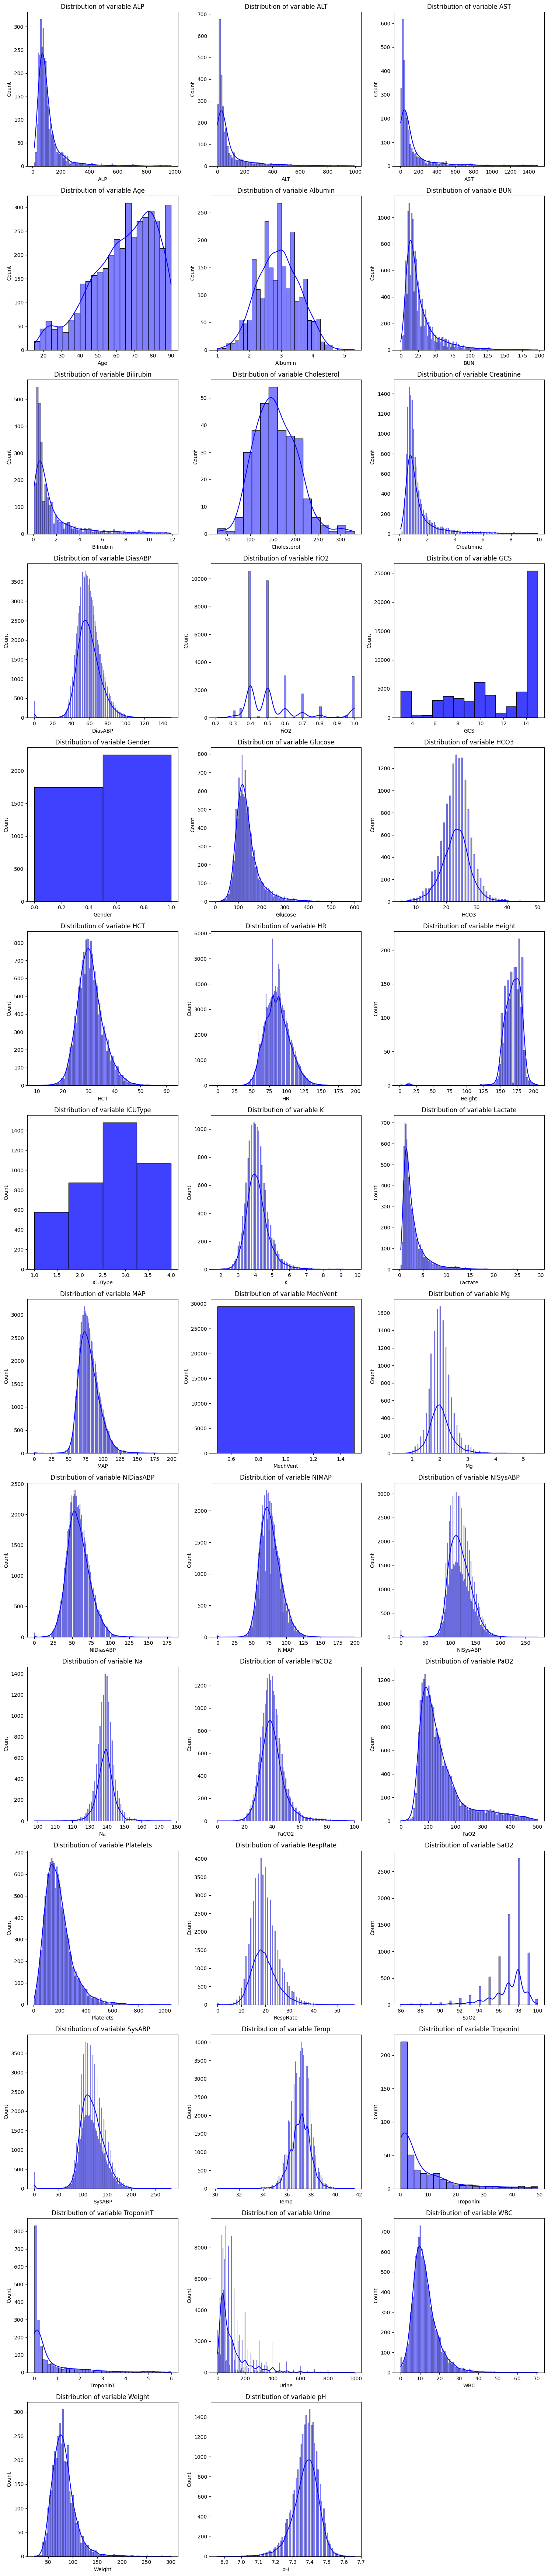

In [10]:
# Temporarily crop some outlier values to make the plot more readable
# Note: Ouliers will be removed in the preprocessing step, this is just for visualization
X_set_a_temp = X_set_a.copy()
X_set_a_temp.loc[X_set_a_temp['ALP'] >= 1000, 'ALP'] = np.nan
X_set_a_temp.loc[X_set_a_temp['ALT'] >= 1000, 'ALT'] = np.nan
X_set_a_temp.loc[X_set_a_temp['AST'] >= 1500, 'AST'] = np.nan
X_set_a_temp.loc[X_set_a_temp['Bilirubin'] >= 12, 'Bilirubin'] = np.nan
X_set_a_temp.loc[X_set_a_temp['Creatinine'] >= 10, 'Creatinine'] = np.nan
X_set_a_temp.loc[X_set_a_temp['DiasABP'] >= 150, 'DiasABP'] = np.nan
X_set_a_temp.loc[X_set_a_temp['Glucose'] >= 600, 'Glucose'] = np.nan
X_set_a_temp.loc[X_set_a_temp['HR'] >= 200, 'HR'] = np.nan
X_set_a_temp.loc[X_set_a_temp['Height'] >= 300, 'Height'] = np.nan
X_set_a_temp.loc[X_set_a_temp['K'] >= 10, 'K'] = np.nan
X_set_a_temp.loc[X_set_a_temp['MAP'] >= 200, 'MAP'] = np.nan
X_set_a_temp.loc[X_set_a_temp['Mg'] >= 6, 'Mg'] = np.nan
X_set_a_temp.loc[X_set_a_temp['RespRate'] >= 60, 'RespRate'] = np.nan
X_set_a_temp.loc[X_set_a_temp['SaO2'] <= 85, 'SaO2'] = np.nan
X_set_a_temp.loc[X_set_a_temp['Temp'] <= 30, 'Temp'] = np.nan
X_set_a_temp.loc[X_set_a_temp['TroponinT'] >= 6, 'TroponinT'] = np.nan
X_set_a_temp.loc[X_set_a_temp['Urine'] >= 1000, 'Urine'] = np.nan
X_set_a_temp.loc[X_set_a_temp['WBC'] >= 75, 'WBC'] = np.nan
X_set_a_temp.loc[X_set_a_temp['pH'] >= 15, 'pH'] = np.nan
X_set_a_temp.loc[X_set_a_temp['pH'] <= 5, 'pH'] = np.nan

plot_distributions(X_set_a_temp, static_columns)

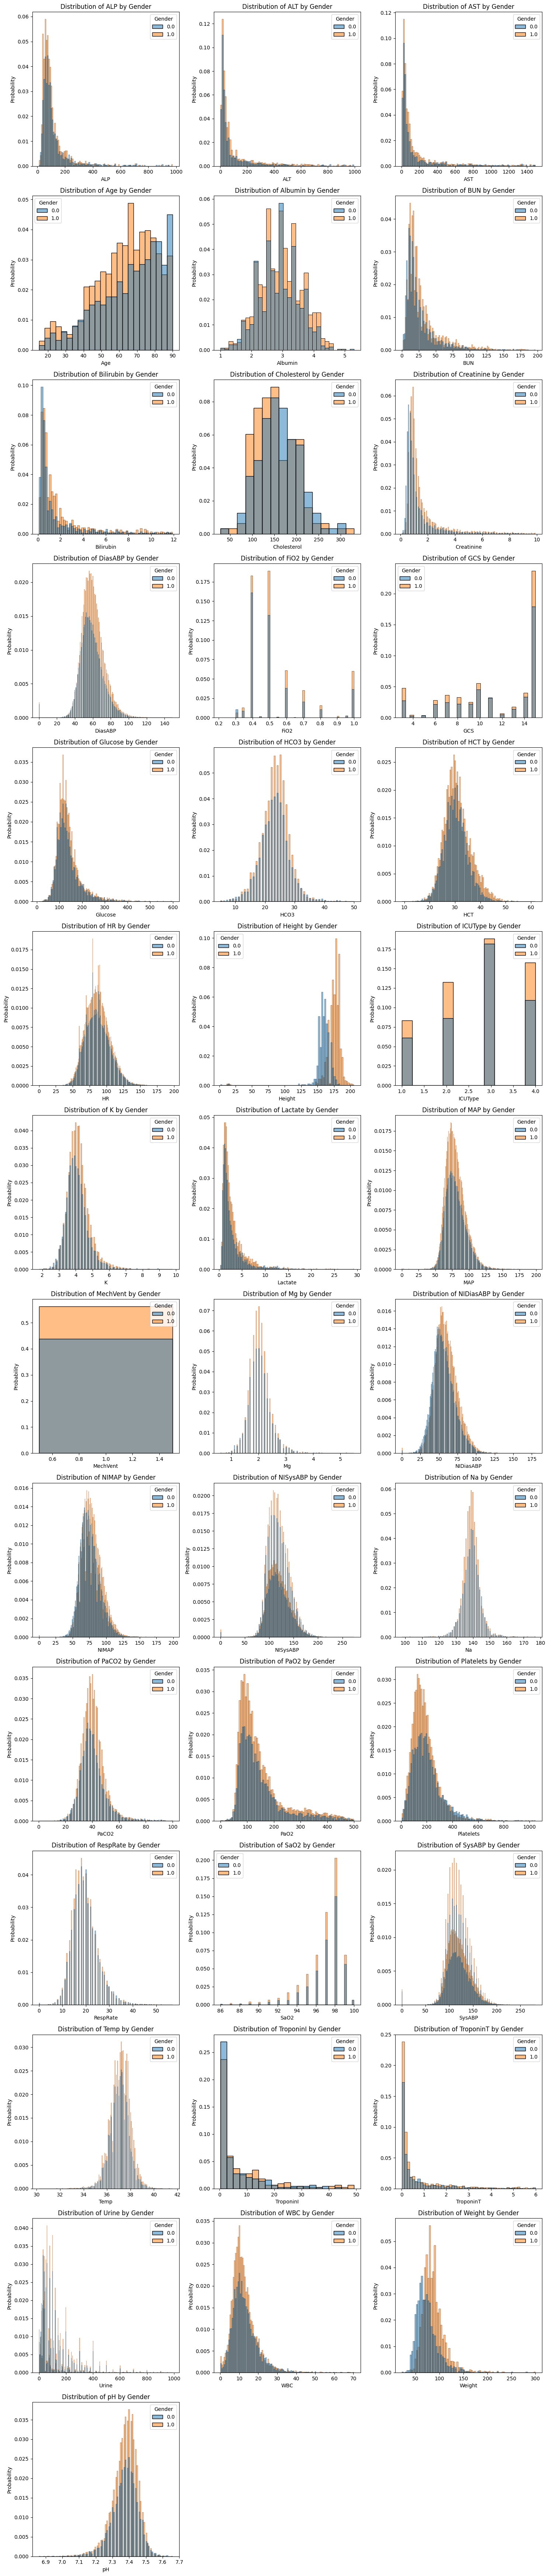

In [11]:
def plot_distributions_by_gender(df, static_columns):
    exclude_cols = ['time', 'recordid', 'Gender']
    cols_to_plot = [col for col in df.columns if col not in exclude_cols]
    num_cols = len(cols_to_plot)

    plt.figure(figsize=(15, 5 * (num_cols // 3 + 1)))
    for i, col in enumerate(cols_to_plot, 1):
        plt.subplot((num_cols // 3) + 1, 3, i)
        if col in static_columns:  # Limit to one datapoint per recordid for static columns
            sns.histplot(data=df.groupby('recordid')[[col, 'Gender']].first(), x=col, hue='Gender', stat='probability')
        else:
            sns.histplot(data=df, x=col, hue='Gender', stat='probability')
        plt.title(f"Distribution of {col} by Gender")
        
    plt.tight_layout()
    plt.show()

plot_distributions_by_gender(X_set_a_temp, static_columns)

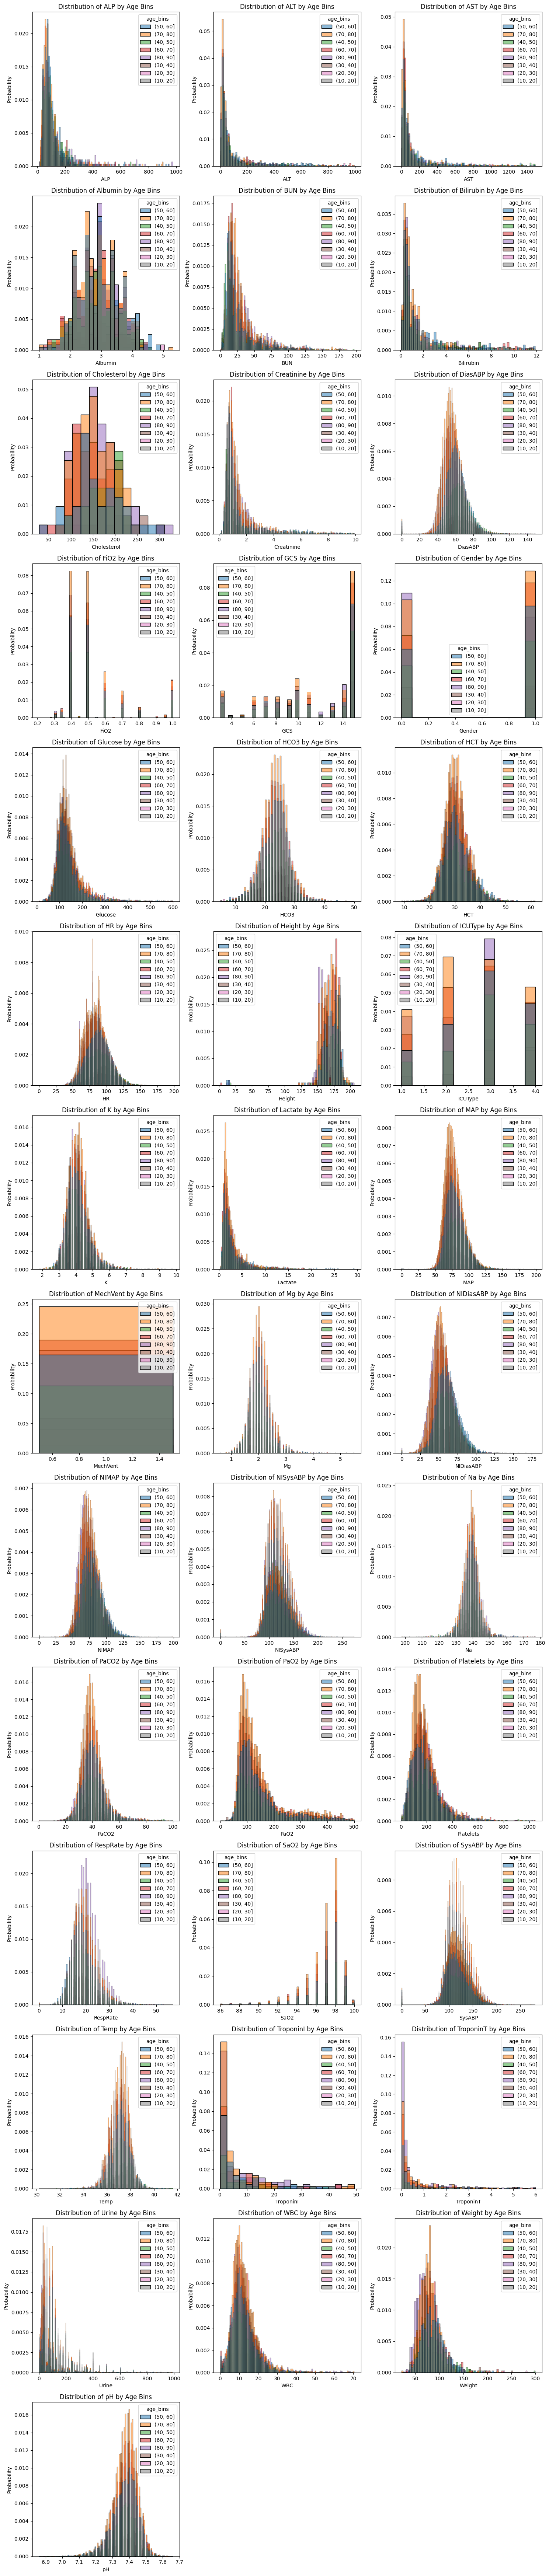

In [12]:
def plot_distributions_by_age_bins(df, static_columns):
    # Create Age Bins (10-year intervals)
    df['age_bins'] = pd.cut(df['Age'], bins=np.arange(0, 100, 10))
    df['age_bins'] = df['age_bins'].astype(str)

    exclude_cols = ['time', 'recordid', 'Age', 'age_bins']
    cols_to_plot = [col for col in df.columns if col not in exclude_cols]
    num_cols = len(cols_to_plot)

    plt.figure(figsize=(15, 5 * (num_cols // 3 + 1)))
    for i, col in enumerate(cols_to_plot, 1):
        plt.subplot(num_cols // 3 + 1, 3, i)
        if col in static_columns:  # Limit to one datapoint per recordid for static columns
            sns.histplot(data=df.groupby('recordid')[[col, 'age_bins']].first(), x=col, hue='age_bins', stat='probability')
        else:
            sns.histplot(data=df, x=col, hue='age_bins', stat='probability')
        plt.title(f"Distribution of {col} by Age Bins")

    plt.tight_layout()
    plt.show()

    df.drop(columns='age_bins', inplace=True)  # Drop the age_bins column after plotting

plot_distributions_by_age_bins(X_set_a_temp, static_columns)

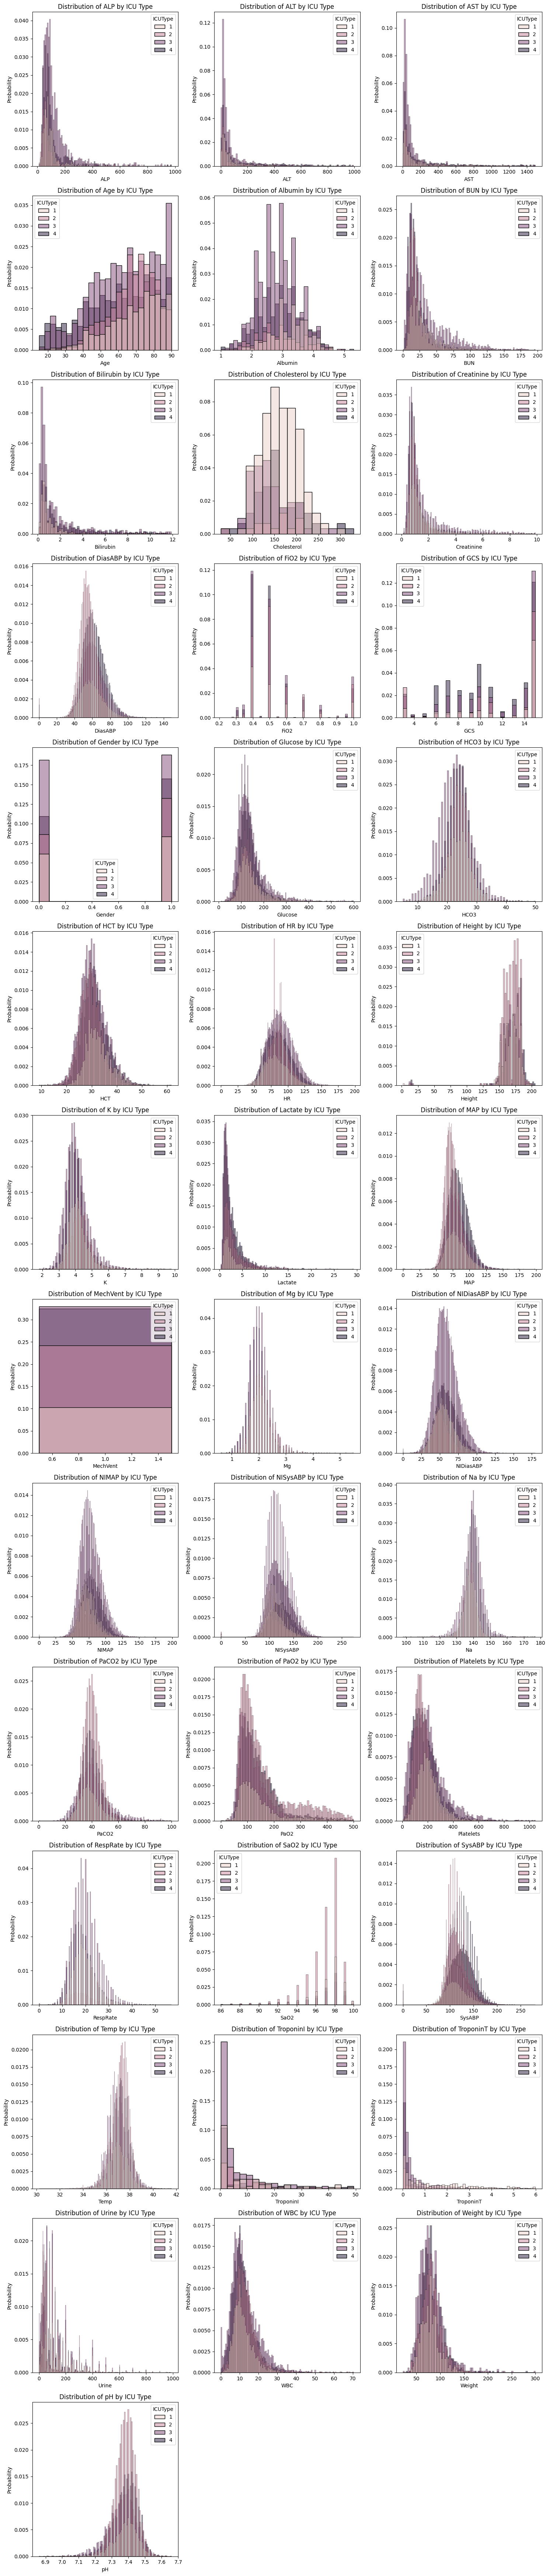

In [13]:
def plot_distributions_by_icu_type(df, static_columns):
    exclude_cols = ['time', 'recordid', 'ICUType']
    cols_to_plot = [col for col in df.columns if col not in exclude_cols]
    num_cols = len(cols_to_plot)

    plt.figure(figsize=(15, 5 * (num_cols // 3 + 1)))
    for i, col in enumerate(cols_to_plot, 1):
        plt.subplot(num_cols // 3 + 1, 3, i)
        if col in static_columns:
            sns.histplot(data=df.groupby('recordid')[[col, 'ICUType']].first(), x=col, hue='ICUType', stat='probability')
        else:
            sns.histplot(data=df, x=col, hue='ICUType', stat='probability')
        plt.title(f"Distribution of {col} by ICU Type")

    plt.tight_layout()
    plt.show()

plot_distributions_by_icu_type(X_set_a_temp, static_columns)

#### Q1.3 Preprocess data for Machine Learning (2 Pts)

In [14]:
# Functions for data cleaning
# Inspired by https://github.com/alistairewj/challenge2012/blob/master/prepare-data.ipynb
# and by feature descriptions in https://physionet.org/content/challenge-2012/1.0.0/

def replace_value(df, c, value=np.nan, below=None, above=None):
    idx = (df[c].notna()) & ((below is not None and df[c] < below) | (above is not None and df[c] > above))
    df.loc[idx, c] = df.loc[idx, c].apply(value) if callable(value) else value
    return df

def clean_data(df): 
    df = replace_value(df, 'DiasABP', value=np.nan, below=1)
    df = replace_value(df, 'DiasABP', value=np.nan, above=200)

    df = replace_value(df, 'FiO2', value=np.nan, below=0, above=1)

    df = replace_value(df, 'GCS', value=np.nan, below=3, above=15)

    df = replace_value(df, 'HCT', value=np.nan, below=0, above=100)

    df = replace_value(df, 'Height', value=np.nan, below=0)
    df = replace_value(df, 'Height', value=lambda x: x*100, below=10)
    df = replace_value(df, 'Height', value=lambda x: x*10, below=25)
    df = replace_value(df, 'Height', value=lambda x: x*2.54, below=100)  # Convert inches to cm
    df = replace_value(df, 'Height', value=lambda x: x*0.1, above=1000)
    df = replace_value(df, 'Height', value=lambda x: x*0.3937, above=250)  # Convert cm to inches

    df = replace_value(df, 'HR', value=np.nan, below=1)
    df = replace_value(df, 'HR', value=np.nan, above=299)

    df = replace_value(df, 'MAP', value=np.nan, below=1)

    df = replace_value(df, 'NIDiasABP', value=np.nan, below=1)

    df = replace_value(df, 'NIMAP', value=np.nan, below=1)
    
    df = replace_value(df, 'NISysABP', value=np.nan, below=1)

    df = replace_value(df, 'PaCO2', value=np.nan, below=1)
    df = replace_value(df, 'PaCO2', value=lambda x: x*10, below=10)

    df = replace_value(df, 'PaO2', value=np.nan, below=1)
    df = replace_value(df, 'PaO2', value=lambda x: x*10, below=20)

    # the order of these steps matters
    df = replace_value(df, 'pH', value=lambda x: x*10, below=0.8, above=0.65)
    df = replace_value(df, 'pH', value=lambda x: x*0.1, below=80, above=65)
    df = replace_value(df, 'pH', value=lambda x: x*0.01, below=800, above=650)
    df = replace_value(df, 'pH', value=np.nan, below=6.5)
    df = replace_value(df, 'pH', value=np.nan, above=8.0)

    df = replace_value(df, 'RespRate', value=np.nan, below=1)
    df = replace_value(df, 'SaO2', value=np.nan, below=1, above=100)

    df = replace_value(df, 'SysABP', value=np.nan, below=1)

    df = replace_value(df, 'Temp', value=np.nan, below=25)
    df = replace_value(df, 'Temp', value=np.nan, above=45)

    df = replace_value(df, 'WBC', value=np.nan, below=1)

    df = replace_value(df, 'Weight', value=np.nan, below=35)
    df = replace_value(df, 'Weight', value=np.nan, above=299)

    return df

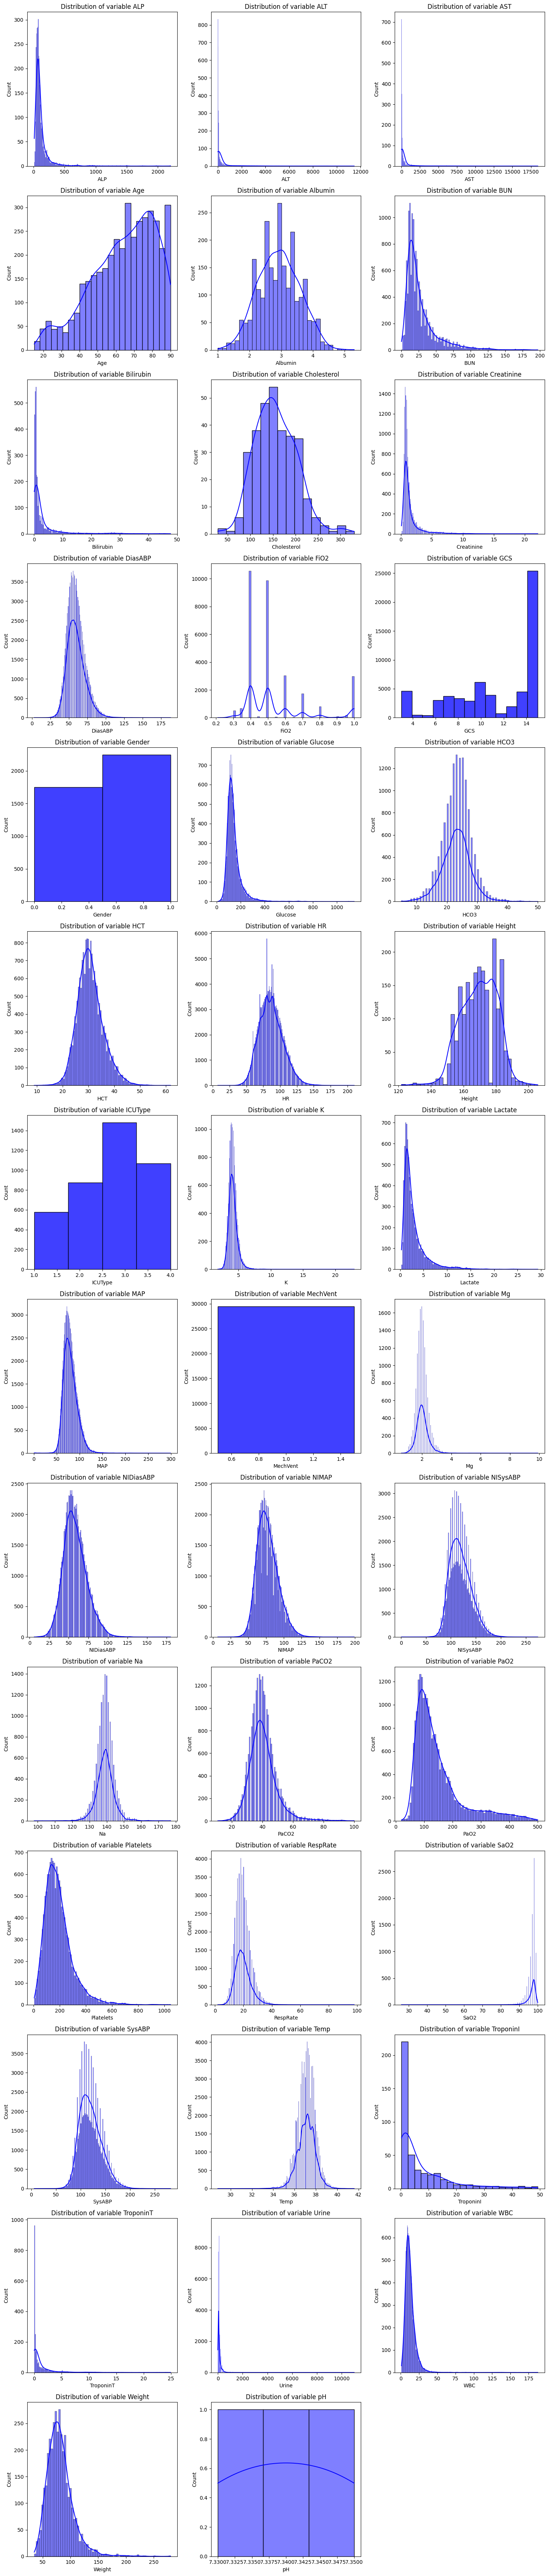

In [15]:
X_set_a = clean_data(X_set_a)

# Plot each column's distribution after cleaning
plot_distributions(X_set_a, static_columns)